# 前提

## インポート

In [97]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from keras.utils import np_utils 
import tqdm
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle

In [98]:
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns', 10)

## モデル

### 普通のLFA

In [99]:
class MatrixFactorization():
    def __init__(self,R,lamda,alpha=0.001,k=60, steps=200,threshold=0.001):
        self.R = R
        self.m = R.shape[0]#Rの列数
        self.n = R.shape[1]#Rの行数
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.k = k #潜在因子分析の次元
        # initializa U and V
        self.U = np.random.rand(self.m, self.k)#0.0から1の範囲でm×k行列の乱数を発生させる
        self.V = np.random.rand(self.k, self.n)#0.0から1の範囲でk×n行列の乱数を発生させる
        self.alpha = alpha #学習率
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                        err_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_ijはr_ijからUのi-1行目とVのj-1列目をかけあわせたものを引いた値
                        for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                            delta_u = self.alpha * (err_ij * self.V[q, j] - self.lamda * self.U[i, q])
                            delta_v = self.alpha * (err_ij * self.U[i, q] - self.lamda * self.V[q, j])
                            self.U[i, q] += delta_u
                            self.V[q, j] += delta_v
                            

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V

### 提案手法１(重みを変えない)

#### どちらにもクラスター

In [164]:
class MatrixFactorization_1_1():
    def __init__(self,R,C,D,U,V,beta,ganma,k=60,steps=200, alpha=0.001,lamda=0.1,threshold=0.001):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.U = U
        self.V = V #転置した状態のものを入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +self.ganma * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (self.ganma * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += self.ganma*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター構造

In [101]:
class MatrixFactorization_1_2():
    def __init__(self,R,C,U,V,beta,k=60,steps=200, alpha=0.01,lamda=0.1,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                
                for j in self.Y:
                    
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + self.beta * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (self.beta * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += self.beta*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

#### サービスのみにクラスター

In [104]:
class MatrixFactorization_1_3():
    def __init__(self,R,D,U,V,ganma,k=60,steps=200, alpha=0.001,lamda=0.1,threshold=0.001):
        self.R = R
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.U = U
        self.V = V #転置した状態のものを入れる
        self.T = np.random.uniform(-0.1,0.1,(self.o,self.k))#-0.1から0.1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.A)
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for k in self.A:
                        d_kj = self.D[k,j]
                        err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] - self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] +self.ganma * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                delta_t = self.alpha * (self.ganma * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
                        
            for j in self.Y:
                #ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += self.ganma*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V,self.T

### 提案手法②(重みを変える)

#### どちらにもクラスター

In [105]:
class MatrixFactorization_2_1():
    def __init__(self,R,C,D,U,V,label_U,label_V,user_clust_std,service_clust_std,beta,ganma,k=60,steps=200, alpha=0.001,lamda=0.1,threshold=0.01):
        self.R = R
        self.C = C
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.label_U=label_U
        self.label_V=label_V
        
        self.user_clust_std=user_clust_std
        self.service_clust_std=service_clust_std
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        self.T = np.random.rand(self.o, self.k)#0.0から1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z,self.A)
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for j in self.Y:
                    ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    #print(r_ij)
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        #print(c_il)
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        #print(err_c_il)
                        for k in self.A:
                            d_kj = self.D[k,j]
                            err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                            #print(err_d_kj)
                            if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                                err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                                #print(err_r_ij)
                                for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                    delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                    delta_v = self.alpha * (err_r_ij * self.U[i, q] +ganma_j * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                    delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                    delta_t = self.alpha * (ganma_j * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                    self.U[i, q] += delta_u
                                    self.V[q, j] += delta_v
                                    self.S[q, l] += delta_s
                                    self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=self.beta*(1/self.user_clust_std[self.label_U[i]])
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
            for j in self.Y:
                ganma_j=self.ganma*(1/self.service_clust_std[self.label_V[j]])
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += ganma_j*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2
            

            if error < self.threshold:
                break
        return self.U, self.V,self.S,self.T

#### ユーザーのみにクラスター

In [106]:
class MatrixFactorization_2_2():
    def __init__(self,R,C,U,V,label_U,user_clust_std,beta,k=60,steps=200, alpha=0.01,lamda=0.1,threshold=0.001):
        self.R = R
        self.C = C
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.l = C.shape[1]#Cの列数
        
        self.label_U=label_U
        self.user_clust_std=user_clust_std
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.Z=np.arange(0,self.l)

        self.k = k #潜在因子分析の次元
        
        
        self.U = U
        self.V = V #転置した状態で入れる
        self.S = np.random.rand(self.k, self.l)#0.0から1の範囲でk×l行列の乱数を発生させる
        
        self.alpha = alpha #学習率
        self.beta = beta #CとPSの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,c,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(c)

    def fit(self):
        for step in range(self.steps):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.Z)
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for l in self.Z:
                        c_il = self.C[i,l] #c_il=C[i,l]とする
                        err_c_il=c_il-np.dot(self.U[i,:],self.S[:,l])#cの誤差
                        
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] + beta_i * err_c_il * self.S[q,l]- self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] - self.lamda * self.V[q, j])
                                delta_s = self.alpha * (beta_i * err_c_il * self.U[i, q] - self.lamda * self.S[q,l])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.S[q, l] += delta_s

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            C_hat = np.dot(self.U, self.S)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
            for i in self.X:
                beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for l in self.Z:
                    c_il = self.C[i,l]
                    c_hat_il = C_hat[i,l]
                    error += beta_i*pow(c_il-c_hat_il,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.S,2).sum()) / 2


            if error < self.threshold:
                break
        return self.U, self.V,self.S

#### サービスのみにクラスター

In [107]:
class MatrixFactorization_2_3():
    def __init__(self,R,C,D,U,V,k,ganma,steps=200, alpha=0.001,lamda=0.1,threshold=0.001):
        self.R = R
        self.D = D
        
        self.m = R.shape[0]#Rの行数
        self.n = R.shape[1]#Rの列数
        self.o = D.shape[0]#Dの行数
        
        self.X=np.arange(0,self.m)
        self.Y=np.arange(0,self.n)
        self.A=np.arange(0,self.o)
        self.k = k #潜在因子分析の次元
        
        self.U = U
        self.V = V #転置した状態のものを入れる
        self.T = np.random.uniform(-0.1,0.1,(self.o,self.k))#-0.1から0.1の範囲でo×k行列の乱数を発生
        
        self.alpha = alpha #学習率
        self.ganma = ganma #DとTVの誤差の係数
        self.lamda = lamda #正則化項の係数
        self.threshold = threshold #誤差の閾値
        self.steps = steps #シャッフルする回数
        
    def shuffle_in_unison_scary(self, a, b,d):
        rng_state = np.random.get_state()
        np.random.shuffle(a)
        np.random.set_state(rng_state)
        np.random.shuffle(b)
        np.random.set_state(rng_state)
        np.random.shuffle(d)

    def fit(self):
        for step in tqdm.tqdm(range(self.steps)):
            error = 0
            self.shuffle_in_unison_scary(self.X,self.Y,self.A)
            for i in self.X:
                #beta_i=round(self.beta*(1/self.user_clust_std[self.label_U[i]]),3)
                for j in self.Y:
                    ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                    r_ij = self.R[i,j] #r_ij=R[i,j]とする
                    for k in self.A:
                        d_kj = self.D[k,j]
                        err_d_kj = d_kj-np.dot(self.T[k,:],self.V[:,j])
                        if r_ij != 0: #Rの要素が0以外の値をとる場合更新する
                            err_r_ij = r_ij - np.dot(self.U[i,:], self.V[:,j]) #誤差err_r_ijはr_ijからUのi行目とVのj列目をかけあわせたものを引いた値
                            for q in range(self.k):#潜在因子分析の次元数であるk回以下を繰り返す
                                delta_u = self.alpha * (err_r_ij * self.V[q, j] - self.lamda * self.U[i, q])
                                delta_v = self.alpha * (err_r_ij * self.U[i, q] +self.ganma * err_d_kj * self.T[k,q]- self.lamda * self.V[q, j])
                                delta_t = self.alpha * (self.ganma * err_d_kj * self.V[q,j] - self.lamda * self.T[k,q])
                                self.U[i, q] += delta_u
                                self.V[q, j] += delta_v
                                self.T[k, q] += delta_t

            R_hat = np.dot(self.U, self.V) #UとVを掛け合わせたものがR_hatになる
            D_hat = np.dot(self.T, self.V)
            for i in self.X:
                for j in self.Y:
                    r_ij = self.R[i, j]
                    r_hat_ij = R_hat[i, j]
                    if r_ij != 0:
                        error += pow(r_ij - r_hat_ij,2)/2
                        
            for j in self.Y:
                ganma_j=round(self.ganma*(1/self.service_clust_std[self.label_V[j]]),3)
                for k in self.A:
                    d_kj = self.D[k,j]
                    d_hat_kj = D_hat[k,j]
                    error += self.ganma*pow(d_kj-d_hat_kj,2)/2
                    
            error += (self.lamda * np.power(self.U,2).sum()) / 2
            error += (self.lamda * np.power(self.V,2).sum()) / 2
            error += (self.lamda * np.power(self.T,2).sum()) / 2

            if error < self.threshold:
                break
        return self.U, self.V,self.T

## 評価指標

In [108]:
def MSE(ar_original,ar_R_hat):#元の欠損する前の行列(array型),欠損した行列,潜在因子行列をかけた行列
    total=0
    x=ar_original.shape[0]
    y=ar_original.shape[1]
    count=x*y
    X=list(range(ar_original.shape[0]))
    Y=list(range(ar_original.shape[1]))
    for i in X:
        for j in Y:    
            total+=(ar_original[i,j]-ar_R_hat[i,j])**2
    score=total/count
    return score

# データ生成

## df_Uを生成

In [123]:
n_samples_per_center=[50,50] #クラスターのそれぞれのデータ数
n_features=60
clust_number=2 #クラスターの数
random_state=12
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
clust_center_1=np.full(n_features,-0.1)#(特徴量数，平均値)
clust_center_2=np.full(n_features,0.1)
centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
cluster_std=np.array([0.08,0.08]) #各クラスターの標準偏差

cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(sum(n_samples_per_center), n_features), dtype=np.float64)
y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)

for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
    start_idx = cum_sum_n_samples[i - 1] if i > 0 else 0
    end_idx = cum_sum_n_samples[i]
    X[start_idx:end_idx] = generator.normal(
        loc=centers[i], scale=std, size=(n, n_features)
    )
    y[start_idx:end_idx] = i
        
X1, y1 = shuffle(X, y, random_state=generator)

Text(0, 0.5, 'Feature 2')

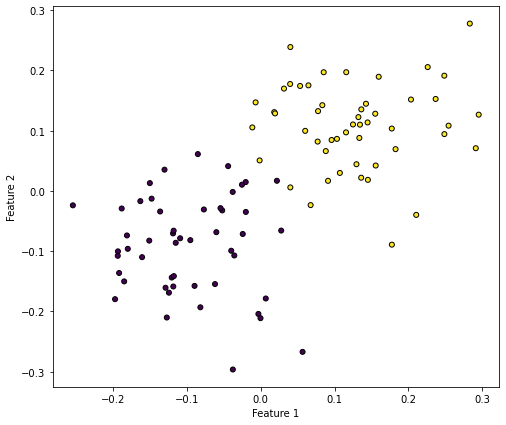

In [124]:
plt.figure(figsize=(8, 7))
plt.scatter(X1[:,0], X1[:,1], marker='o', c=y1, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [125]:
#データフレームに変換
df_U=pd.DataFrame(X1)
df_U_label=y1
df_U_original=df_U.copy()
df_U_original

,0,1,2,3,4,...,55,56,57,58,59
0,-0.062161,-0.154514,-0.080605,-0.236059,-0.039749,...,-0.104113,-0.087217,-0.157301,-0.095958,-0.111467
1,-0.024514,-0.071388,-0.106676,-0.045776,-0.055515,...,-0.151313,-0.210208,-0.022740,-0.202720,-0.201966
2,0.021827,0.016951,-0.096988,-0.119696,-0.153144,...,-0.187081,-0.083822,-0.127987,-0.213702,-0.193087
3,-0.180534,-0.095998,-0.038766,-0.102281,-0.196452,...,0.111124,-0.044711,-0.011101,-0.120615,-0.195676
4,-0.082036,-0.193077,-0.341273,-0.052482,-0.073489,...,-0.101488,-0.149725,-0.072271,0.006999,-0.308400
...,...,...,...,...,...,...,...,...,...,...,...
95,0.060202,0.099820,0.169851,0.265063,0.042072,...,0.158001,0.077338,-0.011050,0.077152,0.211037
96,0.040087,0.238922,0.058168,0.181717,-0.015257,...,-0.061651,0.089626,0.016578,0.147199,0.085271
97,0.210884,-0.039676,0.180756,0.105074,0.194651,...,-0.003593,0.064501,-0.020880,0.140103,0.102664
98,0.133683,0.088060,0.089740,0.136860,0.149373,...,0.166506,0.108253,0.252370,0.025193,0.084661


## df_Vを生成

#### データを生成

In [129]:
n_samples_per_center=[50,50] #クラスターのそれぞれのデータ数
n_features=60
clust_number=2 #クラスターの数
random_state=13
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
clust_center_1=np.full(n_features,-0.1)#(特徴量数，平均値)
clust_center_2=np.full(n_features,0.1)
centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定
#centers=np.array([[-7.5,-7.5],[7.5,7.5],[9,-7.5]]) #クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
cluster_std=np.array([0.08,0.08]) #各クラスターの標準偏差

cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(sum(n_samples_per_center), n_features), dtype=np.float64)
y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)

for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
    start_idx = cum_sum_n_samples[i - 1] if i > 0 else 0
    end_idx = cum_sum_n_samples[i]
    X[start_idx:end_idx] = generator.normal(
        loc=centers[i], scale=std, size=(n, n_features)
    )
    y[start_idx:end_idx] = i
        
X2, y2 = shuffle(X, y, random_state=generator)

Text(0, 0.5, 'Feature 2')

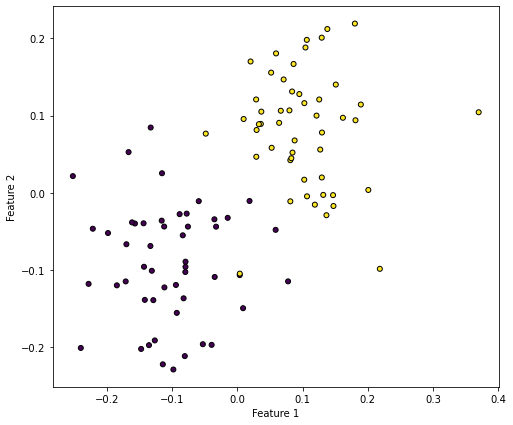

In [130]:
plt.figure(figsize=(8, 7))
plt.scatter(X2[:,0], X2[:,1], marker='o', c=y2, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [131]:
df_V=pd.DataFrame(X1)
df_V_label=y1
df_V_original=df_V.copy()
df_V_original

,0,1,2,3,4,...,55,56,57,58,59
0,-0.156991,-0.039699,-0.103560,-0.063855,0.007608,...,0.061218,-0.104603,-0.054828,-0.071237,-0.140957
1,-0.141853,-0.138510,-0.253933,-0.160596,-0.063722,...,-0.139544,-0.143726,-0.076638,-0.087664,-0.034616
2,-0.088500,-0.027586,-0.067946,-0.161168,-0.181360,...,-0.186087,-0.012458,-0.099631,-0.142815,-0.030530
3,-0.094161,-0.119205,-0.146227,-0.167334,-0.144272,...,-0.254588,-0.024802,-0.023951,-0.212899,-0.003621
4,-0.114264,-0.221857,-0.158565,-0.053988,-0.108257,...,-0.046218,-0.163975,-0.167575,-0.006218,-0.008075
...,...,...,...,...,...,...,...,...,...,...,...
95,0.181047,0.093862,0.134730,0.322412,0.104939,...,0.164675,0.199728,0.076438,0.069048,0.075931
96,0.150847,0.140045,0.094904,0.036626,0.147035,...,0.279524,0.223470,0.037627,0.055545,0.099612
97,0.102504,0.016988,0.065385,0.139713,0.089414,...,0.110848,0.135632,0.113737,0.116951,0.060316
98,0.051741,0.155507,0.118130,0.054966,0.223789,...,0.009565,0.022406,0.018570,0.053622,0.123235


#### ランダムに生成

Text(0, 0.5, 'Feature 2')

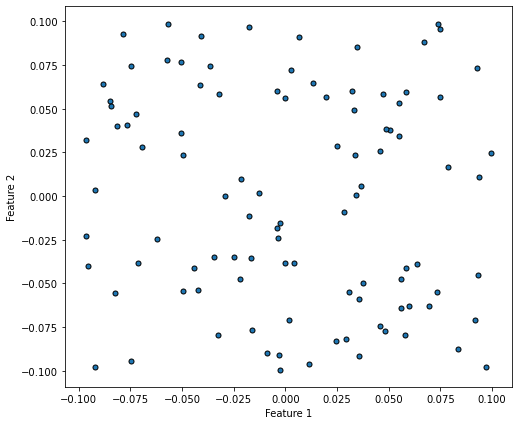

In [94]:
df_V = np.random.uniform(-0.1,0.1,(100,60))
plt.figure(figsize=(8, 7))
plt.scatter(df_V[:,0], df_V[:,1], marker='o', s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [794]:
df_V=pd.DataFrame(df_V)
df_V

,0,1,2,3,4,...,95,96,97,98,99
0,0.491529,0.629279,0.446803,0.075837,0.645685,...,0.065423,0.627562,0.199905,0.500108,0.538234
1,0.133422,0.956752,0.976849,0.048043,0.050593,...,0.114337,0.092249,0.600324,0.114698,0.383453
2,0.170785,0.279346,0.263780,0.783439,0.941532,...,0.760159,0.921075,0.801040,0.471537,0.670120
3,0.221805,0.792272,0.223590,0.246991,0.475233,...,0.636165,0.820037,0.280682,0.772423,0.980103
4,0.226672,0.234098,0.539817,0.728457,0.999579,...,0.036859,0.932482,0.424561,0.180354,0.289324
...,...,...,...,...,...,...,...,...,...,...,...
95,0.655043,0.955607,0.595142,0.058293,0.366592,...,0.205327,0.877630,0.639801,0.671680,0.833383
96,0.322139,0.481048,0.636871,0.171021,0.946025,...,0.358588,0.778025,0.887023,0.560682,0.882331
97,0.864776,0.588942,0.229078,0.950369,0.694705,...,0.384949,0.595585,0.030317,0.929509,0.055218
98,0.141045,0.173097,0.583344,0.217758,0.654407,...,0.600446,0.134353,0.944298,0.589222,0.961902


## df_Rを生成

### 掛け合わせる

In [132]:
ar_U=df_U.values
ar_VT=df_V.values.T
R=np.dot(ar_U,ar_VT)
R

array([[ 0.55498461,  0.81924202,  0.70778133, ..., -0.51555968,
        -0.79135151, -0.70046548],
       [ 0.58568881,  0.77652606,  0.62806152, ..., -0.5726793 ,
        -0.80462709, -0.60181858],
       [ 0.49789194,  0.80842951,  0.7901625 , ..., -0.61396334,
        -0.79152437, -0.64217882],
       ...,
       [-0.48202614, -0.59425931, -0.63050182, ...,  0.52165216,
         0.6814433 ,  0.47134121],
       [-0.46399652, -0.71135702, -0.63762095, ...,  0.55830063,
         0.62890524,  0.58773778],
       [-0.67462666, -0.77529759, -0.76806081, ...,  0.75217666,
         0.73732719,  0.72594769]])

### 誤差を乗せる

In [133]:
n_samples=100 #クラスターのそれぞれのデータ数
n_features=100
#clust_number=2 #クラスターの数
random_state=12
#center_box=(-10,10)

generator = check_random_state(random_state)

#centers=generator.uniform(center_box[0],center_box[1],size=(clust_number,n_features)) #(クラスターの中心の範囲,size(クラスターの中心数，特徴量))
centers=np.full(n_features,0)#(特徴量数，平均値)
#clust_center_2=np.full(n_features,0.1)
#centers=np.array([[clust_center_1],[clust_center_2]])#クラスターの中心の座標を指定

#cluster_std=np.full(len(centers),1.0) #(クラスターの中心数,クラスター内標準偏差)
std=0.01 #各クラスターの標準偏差

#cum_sum_n_samples = np.cumsum(n_samples_per_center) #累積和の配列を作る

X = np.empty(shape=(n_samples, n_features), dtype=np.float64)
#y = np.empty(shape=(sum(n_samples_per_center),), dtype=int)


X[0:100] = generator.normal(
    loc=centers, scale=std, size=(n_samples, n_features))
        
X

array([[ 0.00472986, -0.00681426,  0.00242439, ..., -0.01446359,
        -0.00536481,  0.00197921],
       [-0.0136564 , -0.01194444,  0.00015935, ...,  0.00367393,
        -0.00959012, -0.01595297],
       [ 0.00507523, -0.00618371,  0.00790793, ...,  0.0034661 ,
         0.01337491, -0.02604996],
       ...,
       [-0.01714703,  0.00880748,  0.00918556, ..., -0.00290082,
        -0.00326166, -0.0083153 ],
       [ 0.00967321,  0.00570789, -0.00988034, ..., -0.00339962,
        -0.00550184, -0.01542173],
       [-0.02300419,  0.00685886, -0.01576602, ..., -0.00095875,
        -0.00086353,  0.00068703]])

### 足してデータフレームに

In [134]:
R=R+X
R

array([[ 0.55971447,  0.81242776,  0.71020572, ..., -0.53002327,
        -0.79671633, -0.69848628],
       [ 0.57203241,  0.76458161,  0.62822086, ..., -0.56900537,
        -0.81421721, -0.61777155],
       [ 0.50296717,  0.80224581,  0.79807043, ..., -0.61049723,
        -0.77814945, -0.66822879],
       ...,
       [-0.49917317, -0.58545183, -0.62131626, ...,  0.51875133,
         0.67818164,  0.46302591],
       [-0.45432331, -0.70564913, -0.64750129, ...,  0.55490101,
         0.6234034 ,  0.57231605],
       [-0.69763084, -0.76843873, -0.78382683, ...,  0.75121791,
         0.73646366,  0.72663471]])

In [135]:
df_R=pd.DataFrame(R)
df_R

,0,1,2,3,4,...,95,96,97,98,99
0,0.559714,0.812428,0.710206,0.651993,0.609536,...,-0.811927,-0.697173,-0.530023,-0.796716,-0.698486
1,0.572032,0.764582,0.628221,0.704220,0.611889,...,-0.687922,-0.877642,-0.569005,-0.814217,-0.617772
2,0.502967,0.802246,0.798070,0.826225,0.577499,...,-0.691291,-0.713042,-0.610497,-0.778149,-0.668229
3,0.700987,0.821149,0.705587,0.649822,0.620625,...,-0.696565,-0.753379,-0.603139,-0.851030,-0.712632
4,0.611890,0.763657,0.762339,0.757046,0.700803,...,-0.724201,-0.775825,-0.650256,-0.877638,-0.688848
...,...,...,...,...,...,...,...,...,...,...,...
95,-0.526550,-0.699092,-0.626518,-0.675721,-0.539126,...,0.634300,0.744576,0.488157,0.763653,0.666918
96,-0.476981,-0.640180,-0.531044,-0.595505,-0.520765,...,0.524223,0.600272,0.464039,0.620292,0.542993
97,-0.499173,-0.585452,-0.621316,-0.646289,-0.548299,...,0.620760,0.630617,0.518751,0.678182,0.463026
98,-0.454323,-0.705649,-0.647501,-0.634193,-0.610820,...,0.687910,0.663248,0.554901,0.623403,0.572316


### プロット

Text(0, 0.5, 'Feature 2')

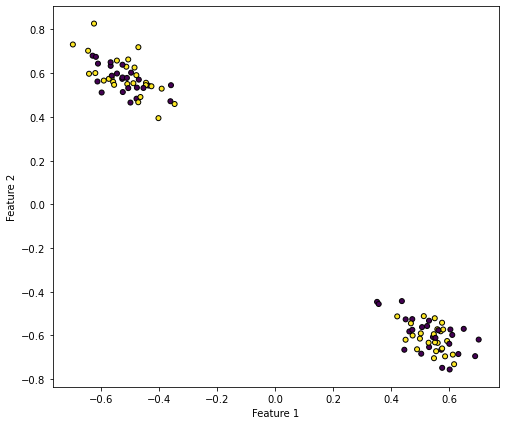

In [136]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R[0],df_R[61], marker='o', c=y1, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

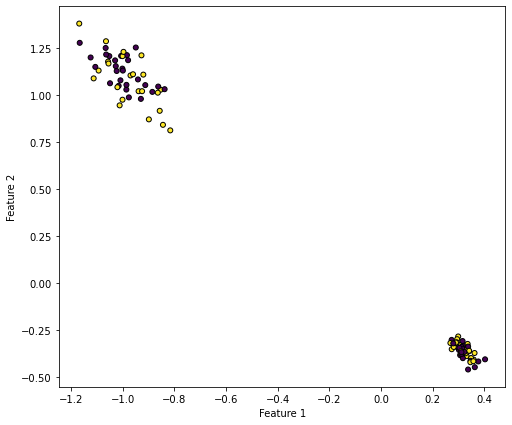

In [68]:
plt.figure(figsize=(8, 7))
plt.scatter(df_R.iloc[1],df_R.iloc[55], marker='o', c=y2, s=25, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [137]:
df_R.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R_original.csv")

## 欠損を生成

In [138]:
def make_null(df,index,col_name): #データフレーム,発生させた乱数,列名
  df1 = df.drop(index) #欠損しないindexを集めたデータ
  df2 = df.iloc[index, :] #欠損するindexを集めたデータ
  df_c = df2[col_name] #欠損するindexを集めたデータの列名を指定
  df2[col_name] = np.nan #nanに置き換え
  result_df = pd.concat([df1,df2]).sort_index() #df1とdf2をくっつける
  return result_df, df_c #くっつけたデータと欠損した列名を返す

In [139]:
df_R_missing=pd.DataFrame()
np.random.seed(11) #乱数のシード値
for i in list(range(100)):#range(データフレームの列数)
    rand_mcar = np.sort(np.random.choice(df_R.index,70,replace=False)) #df1のインデックス番号からx個重複を許さず乱数発生
    dfR_result , mcar_correct = make_null(df_R, rand_mcar,i)
    dfR_result=list(dfR_result[i])
    df_R_missing.insert(i,i,dfR_result)

<ipython-input-138-7a8f389ec19c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col_name] = np.nan #nanに置き換え


In [140]:
df_R_missing

,0,1,2,3,4,...,95,96,97,98,99
0,NaN,NaN,0.710206,NaN,NaN,...,NaN,-0.697173,NaN,-0.796716,NaN
1,0.572032,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.826225,NaN,...,NaN,-0.713042,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0.620625,...,NaN,NaN,-0.603139,-0.851030,-0.712632
4,0.611890,0.763657,NaN,0.757046,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,-0.699092,NaN,-0.675721,-0.539126,...,NaN,NaN,NaN,0.763653,0.666918
96,NaN,NaN,-0.531044,NaN,NaN,...,NaN,NaN,0.464039,NaN,NaN
97,NaN,-0.585452,NaN,-0.646289,NaN,...,0.62076,0.630617,NaN,NaN,NaN
98,NaN,NaN,NaN,-0.634193,-0.610820,...,NaN,NaN,0.554901,NaN,NaN


In [141]:
df_R_missing.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_R__missing_original.csv")

# 分析

## 1回目のLFA

In [143]:
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for lam in [0.1,0.01,0.001]:
    mf = MatrixFactorization(ar_R_missing,lam)
    U,V=mf.fit()
    ar_R_hat=np.dot(U,V)
    ar_R=df_R.values
    score=MSE(ar_R,ar_R_hat)
    score_lis.append(score)
    U_lis.append(U)
    V_lis.append(V)
score_lis

100%|██████████| 200/200 [01:45<00:00,  1.89it/s]


[0.1561921629727393, 0.4317900298692527, 0.5586488055391207]

In [145]:
ar_U1=U_lis[0]
df_U1=pd.DataFrame(ar_U1)
df_U1

,0,1,2,3,4,...,55,56,57,58,59
0,-0.206562,0.444291,-0.288675,-0.052298,0.379868,...,0.025593,0.055006,0.051538,0.323869,0.613535
1,-0.201913,0.207641,0.259702,0.241956,0.197815,...,0.177305,0.080683,0.011741,-0.137883,-0.086687
2,-0.046333,0.173530,-0.254354,0.392116,0.053403,...,-0.193162,-0.078210,0.112446,-0.038476,0.279197
3,0.082859,0.125447,0.272569,0.196650,0.065438,...,-0.167782,-0.178497,-0.148024,0.133550,0.097041
4,0.028839,0.314168,0.179776,-0.105659,0.140470,...,0.182784,0.210648,-0.062183,0.202518,0.033169
...,...,...,...,...,...,...,...,...,...,...,...
95,0.402404,0.069348,0.020161,-0.100780,0.065354,...,0.017512,0.123440,0.347602,0.047737,-0.046413
96,0.230874,-0.200767,0.078232,-0.110440,-0.071877,...,0.244818,0.188633,0.295700,-0.008827,0.328753
97,0.271966,-0.155431,-0.146010,-0.097475,0.194237,...,0.113259,-0.010656,-0.046758,0.006502,0.413643
98,0.432447,0.043861,0.213220,0.014637,0.057272,...,0.231986,0.123862,0.507241,0.185092,0.225835


In [173]:
ar_V1=V_lis[0]
df_V1=pd.DataFrame(ar_V1)
df_V1T=df_V1.T
df_V1

,0,1,2,3,4,...,95,96,97,98,99
0,-0.021876,-0.134848,-0.231892,-0.141703,0.033495,...,0.384900,0.042999,0.247091,0.099261,0.329965
1,0.009761,-0.035448,-0.061137,-0.131502,-0.076421,...,0.078614,0.054050,0.187490,0.106280,0.044567
2,0.217171,0.056153,-0.015328,0.039034,0.219588,...,0.033064,0.050752,0.103296,0.164419,0.368478
3,-0.091190,0.107229,0.210114,0.083856,-0.093982,...,-0.221195,-0.085064,0.072890,-0.034083,-0.310020
4,0.265186,-0.151313,0.182657,-0.105933,0.066841,...,0.281739,0.229073,0.142394,-0.304584,-0.046065
...,...,...,...,...,...,...,...,...,...,...,...
55,0.163974,0.143272,0.025229,-0.000506,0.181715,...,0.102276,0.471342,0.230023,0.194094,0.146020
56,0.017533,0.251565,-0.027766,-0.078901,-0.037520,...,0.150142,0.112848,0.163012,0.205777,0.241431
57,-0.370116,0.004744,-0.066034,-0.182147,-0.054062,...,0.244882,0.114310,0.053393,-0.033256,0.182568
58,0.047906,-0.114199,0.083219,0.307779,0.276285,...,0.001609,-0.113907,-0.007829,0.262443,0.030919


In [147]:
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1.csv")

In [174]:
df_V1T.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1.csv")

## RでDPクラスタリング

## DPクラスタリングの結果をono-hotエンコーディングする

In [149]:
df_U1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_clustering_result.csv")
df_U1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.206562,0.444291,-0.288675,-0.052298,...,0.055006,0.051538,0.323869,0.613535,1
1,2,-0.201913,0.207641,0.259702,0.241956,...,0.080683,0.011741,-0.137883,-0.086687,1
2,3,-0.046333,0.173530,-0.254354,0.392116,...,-0.078210,0.112446,-0.038476,0.279197,1
3,4,0.082859,0.125447,0.272569,0.196650,...,-0.178497,-0.148024,0.133550,0.097041,1
4,5,0.028839,0.314168,0.179776,-0.105659,...,0.210648,-0.062183,0.202518,0.033169,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.402404,0.069348,0.020161,-0.100780,...,0.123440,0.347602,0.047737,-0.046413,0
96,97,0.230874,-0.200767,0.078232,-0.110440,...,0.188633,0.295700,-0.008827,0.328753,0
97,98,0.271966,-0.155431,-0.146010,-0.097475,...,-0.010656,-0.046758,0.006502,0.413643,0
98,99,0.432447,0.043861,0.213220,0.014637,...,0.123862,0.507241,0.185092,0.225835,0


In [169]:
label_U1=df_U1_re["clust_label"]
label_U1_onehot=np_utils.to_categorical(label_U1)
#label_U1_onehot=np.tile(label_U1_onehot,50)
label_U1_onehot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [175]:
df_V1_re=pd.read_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_clustering_result.csv")
df_V1_re

,Unnamed: 0,X0,X1,X2,X3,...,X56,X57,X58,X59,clust_label
0,1,-0.021876,0.009761,0.217171,-0.091190,...,0.017533,-0.370116,0.047906,0.022324,1
1,2,-0.134848,-0.035448,0.056153,0.107229,...,0.251565,0.004744,-0.114199,0.031622,1
2,3,-0.231892,-0.061137,-0.015328,0.210114,...,-0.027766,-0.066034,0.083219,0.072585,1
3,4,-0.141703,-0.131502,0.039034,0.083856,...,-0.078901,-0.182147,0.307779,-0.262342,1
4,5,0.033495,-0.076421,0.219588,-0.093982,...,-0.037520,-0.054062,0.276285,0.103018,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.384900,0.078614,0.033064,-0.221195,...,0.150142,0.244882,0.001609,0.433311,0
96,97,0.042999,0.054050,0.050752,-0.085064,...,0.112848,0.114310,-0.113907,0.085184,0
97,98,0.247091,0.187490,0.103296,0.072890,...,0.163012,0.053393,-0.007829,0.080314,0
98,99,0.099261,0.106280,0.164419,-0.034083,...,0.205777,-0.033256,0.262443,-0.061056,0


In [178]:
label_V1=df_V1_re["clust_label"]
label_V1_onehot=np_utils.to_categorical(label_V1)
label_V1_onehot=label_V1_onehot.T
#label_V1_onehot=np.tile(label_V1_onehot,(50,1))
label_V1_onehot

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

## ユーザーのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [179]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_U1_DCALF-A.csv")
df_U1_0=df_U1[df_U1["clust_label"]==0]
df_U1_0=df_U1_0.iloc[:,:60]
df_U1_0_std=df_U1_0.describe().loc['std'].mean()
df_U1_0_std

0.1623217354090045

In [181]:
df_U1_0

,0,1,2,3,4,...,55,56,57,58,59
50,0.131117,-0.270992,0.278422,-0.117707,0.096082,...,-0.097488,-0.149043,0.115822,0.062218,0.194118
51,0.103249,-0.230557,-0.089679,0.032689,-0.022271,...,0.218624,0.181516,0.288384,0.309623,0.375463
52,0.054627,0.055807,0.052701,0.233385,0.236382,...,0.013576,0.459698,0.123715,0.168924,0.200444
53,0.217917,-0.185611,0.368743,0.004449,0.286898,...,0.109248,0.117288,0.256319,-0.122975,0.427720
54,0.374245,-0.084572,0.033260,0.023483,0.330249,...,0.195661,0.356162,0.110955,0.237749,-0.096010
...,...,...,...,...,...,...,...,...,...,...,...
95,0.402404,0.069348,0.020161,-0.100780,0.065354,...,0.017512,0.123440,0.347602,0.047737,-0.046413
96,0.230874,-0.200767,0.078232,-0.110440,-0.071877,...,0.244818,0.188633,0.295700,-0.008827,0.328753
97,0.271966,-0.155431,-0.146010,-0.097475,0.194237,...,0.113259,-0.010656,-0.046758,0.006502,0.413643
98,0.432447,0.043861,0.213220,0.014637,0.057272,...,0.231986,0.123862,0.507241,0.185092,0.225835


### クラスが1のデータのクラスター内標準偏差

In [155]:
df_U1["clust_label"]=df_U1_re["clust_label"]
df_U1_1=df_U1[df_U1["clust_label"]==1]
df_U1_1=df_U1_1.iloc[:,:60]
df_U1_1_std=df_U1_1.describe().loc['std'].mean()
df_U1_1_std

0.16184326523880793

### リストに格納

In [156]:
user_clust_std=list([df_U1_0_std,df_U1_1_std])
user_clust_std

[0.1623217354090045, 0.16184326523880793]

## サービスのクラスター内標準偏差を計算

### クラスが0のデータのクラスター内標準偏差

In [182]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1.to_csv("/Users/kiyopippi/Desktop/卒業研究/データ/df_V1_DCALF-A.csv")
df_V1_0=df_V1[df_V1["clust_label"]==0]
df_V1_0=df_V1_0.iloc[:,:60]
df_V1_0_std=df_V1_0.describe().loc['std'].mean()
df_V1_0_std

0.18348800313974636

### クラスが1のデータのクラスター内標準偏差

In [183]:
df_V1["clust_label"]=df_V1_re["clust_label"]
df_V1_1=df_V1[df_V1["clust_label"]==1]
df_V1_1=df_V1_1.iloc[:,:60]
df_V1_1_std=df_V1_1.describe().loc['std'].mean()
df_V1_1_std

0.18024529709919393

### リストに格納


In [184]:
service_clust_std=list([df_V1_0_std,df_V1_1_std])
service_clust_std

[0.18348800313974636, 0.18024529709919393]

## 2回目のLFA

#### 重み変えない+ユーザのみクラスター

In [413]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for beta in [1.0,0.1.0.01]:
    mf = MatrixFactorization_1_2(ar_R_missing,C,ar_U1,ar_V1,beta)
    U,VT,S=mf.fit()
    ar_R_hat=np.dot(U,VT)
        ar_R=df_R.values
        score=MSE(ar_R,ar_R_hat)
        score_lis.append(score)
        U_lis.append(U)
        V_lis.append(V)
score_lis

#### 重み変えない+サービスのみクラスター

In [ ]:
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for ganma in [1.0,0.1.0.01]:
    mf = MatrixFactorization_1_3(ar_R_missing,D,ar_U1,ar_V1,ganma)
    U,VT,T=mf.fit()
    ar_R_hat=np.dot(U,VT)
        ar_R=df_R.values
        score=MSE(ar_R,ar_R_hat)
        score_lis.append(score)
        U_lis.append(U)
        V_lis.append(V)
score_lis

#### 重み変えない＋両方クラスター


In [ ]:
C=label_U1_onehot
D=label_V1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for beta in [1.0,0.1,0.01]:
    for ganma in [1.0,0.1,0.01]:
        mf = MatrixFactorization_1_1(ar_R_missing,C,D,ar_U1,ar_V1,beta,ganma)
        U,VT,S,T=mf.fit()
        ar_R_hat=np.dot(U,VT)
        ar_R=df_R.values
        score=MSE(ar_R,ar_R_hat)
        score_lis.append(score)
        U_lis.append(U)
        V_lis.append(V)
score_lis

 24%|██▍       | 49/200 [04:40<18:16,  7.26s/it]

## 2回目のLFA(重みを変える)

#### 重み変える+ユーザのみクラスター

In [409]:
C=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for beta in [1.0,0.1,0.01]:
    mf = MatrixFactorization_2_2(ar_R_missing,C,ar_U1,ar_V1,label_U1,user_clust_std,beta)
    U,VT,S=mf.fit()
    ar_R_hat=np.dot(U,VT)
    ar_R=df_R.values
    score=MSE(ar_R,ar_R_hat)
    score_lis.append(score)
    U_lis.append(U)
    V_lis.append(V)
score_lis

#### 重み変える+サービスのみクラスター

In [ ]:
D=label_U1_onehot
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
score_lis=[]
U_lis=[]
V_lis=[]
for ganma in [1.0,0.1,0.01]:
    mf = MatrixFactorization_2_3(ar_R_missing,D,ar_U1,ar_V1,label_V1,service_clust_std,ganma)
    U,VT,T=mf.fit()
    ar_R_hat=np.dot(U,VT)
    ar_R=df_R.values
    score=MSE(ar_R,ar_R_hat)
    score_lis.append(score)
    U_lis.append(U)
    V_lis.append(V)
score_lis

#### 重み変える+両方クラスター

In [720]:
df_R_missing=df_R_missing.fillna(0) #欠損値を０で穴埋め
ar_R_missing=df_R_missing.values #データフレームをarray型に変換
C=label_U1_onehot
D=label_V1_onehot
score_lis=[]
U_lis=[]
V_lis=[]
for beta in [1.0,0.1,0.01]:
    for ganma in [1.0,0.1,0.01]:
        mf = MatrixFactorization_2_1(ar_R_missing,C,D,ar_U1,ar_V1,label_U1,label_V1,user_clust_std,service_clust_std,beta,ganma)
        U,VT,S,T=mf.fit()
        ar_R_hat=np.dot(U,VT)
        ar_R=df_R.values
        score=MSE(ar_R,ar_R_hat)
        score_lis.append(score)
        U_lis.append(U)
        V_lis.append(V)
score_lis



100%|██████████| 200/200 [15:51<00:00,  4.76s/it]
